# Tutorial: creating river concentrations file for MITgcm LLC family of grids (here ASTE)

The purpose of this package is to create gridded files of river biogeochemical properties. Such properties are measured locally or inferred at the mouth of the river and provided in spreadsheet-style databases. To force ocean model, we need gridded files of BGC concentrations, that can be multiplied by river and coastal runoff to create the riverine flux into the ocean. DICRIVERS will find the closest gridpoint to the true river mouth geographical location, then create a "plume"
(i.e. a binary mask) on which to apply the concentration of each given river.

In [1]:
import xarray as xr
import pandas as pd
from dicrivers import make_bgc_river_input
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Open the included example dataframe of the 20 largest rivers:

In [3]:
river_df = pd.read_csv('../dicrivers/test/data/20major_rivers.csv')

In [4]:
river_df

,basinid,basinname,mouth_lon,mouth_lat,rspread,testvar
0,1,Amazon,-51.75,-1.25,5,99
1,2,Nile,31.25,31.25,5,98
2,3,Zaire,12.75,-5.75,5,97
3,4,Mississippi,-90.25,29.75,5,96
4,5,Ob,69.25,66.75,5,95
5,6,Parana,-58.75,-34.25,5,94
6,7,Yenisei,82.25,71.25,5,93
7,8,Lena,127.25,73.25,5,92
8,9,Niger,6.75,4.75,5,91
9,10,Tamanrasett,-16.25,20.25,5,90


The example dataframe contains the longitude and latitude of the river mouth, the desired radius of spreading for each river plume and values for the various biogeochemical properties. Here the radius is of 5 grid points in each direction from the river mouth. This can be adjusted on an individual basis. As a rule of thumb, the higher the horizontal resolution the larger the spreading for a plume of similar extension.

The pandas framework allows you to add variables, select and sort entries very easily. Next we need the grid onto which to generate the plumes:

In [5]:
aste_grid = xr.open_dataset('../dicrivers/test/data/aste_grid_surf.nc')

ASTE is a regional domain, from the LLC family of grids used in MITgcm. The file used here was obtained with xmitgcm (https://xmitgcm.readthedocs.io/en/latest/index.html). NB: to save space in the repo, I extracted surface level of hFacC. If you use the original 3d variable, you need to select level k=0.

In [6]:
aste_grid

<xarray.Dataset>
Dimensions:  (face: 6, i: 270, j: 270, k: 1)
Coordinates:
  * face     (face) int32 0 1 2 3 4 5
    hFacC    (k, face, j, i) float32 ...
  * i        (i) int32 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * j        (j) int32 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * k        (k) int32 0
Data variables:
    XC       (face, j, i) float64 ...
    YC       (face, j, i) float64 ...
Attributes:
    history:                    Thu Jun  6 11:52:57 2019: ncks -d k,0,0 ASTE_...
    NCO:                        netCDF Operators version 4.7.7 (Homepage = ht...
    history_of_appended_files:  Thu Jun  6 11:50:52 2019: Appended file aste_...

The xarray dataset contains the longitude, latitude of tracer points (look up Arakawa staggered grid for more details) and
a land sea mask. The land sea mask is used to constrain the various plumes not to contaminate adjacent estuaries.

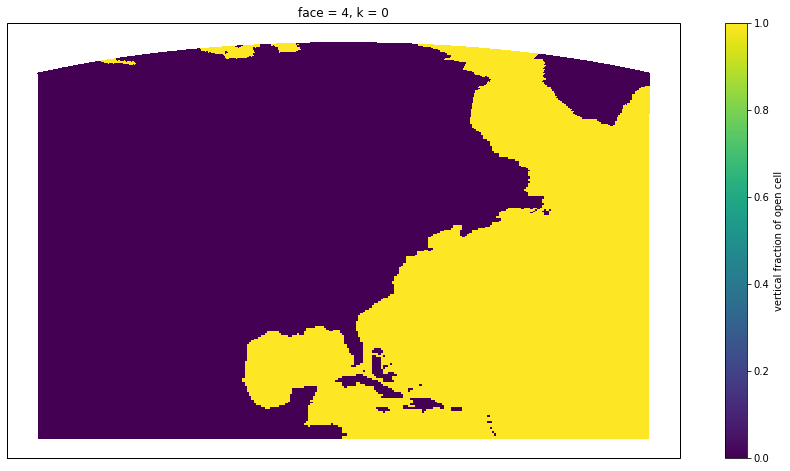

In [7]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.PlateCarree())
landseamask = aste_grid['hFacC'].assign_coords(lon=aste_grid['XC'], lat=aste_grid['YC'])
landseamask.sel(face=4).plot(ax=ax, x='lon', y='lat', 
                             transform=ccrs.PlateCarree())

To generate the concentration arrays, we use the **make_bgc_river_input** function. The arguments are the river dataframe, the list of variables we want, lon/lat/mask of the ocean grid. Optional parameters control the *method* used to merge the plumes (default='average'), the proximity range *prox* to apply (default=200 km) and the max number of iterations allowed *nitermax* for the plume spreading algo (default=1000).

Here, because of the composite grid, we need to loop over faces and concatenate the end result:

In [8]:
river_conc = xr.Dataset()

for face in range(len(aste_grid.face)):
    river_face = make_bgc_river_input(river_df, ['testvar'],
                                      aste_grid['XC'].sel(face=face).values,
                                      aste_grid['YC'].sel(face=face).values,
                                      aste_grid['hFacC'].sel(face=face, k=0).values,
                                      prox=300.)
    if face == 0:
        river_conc = river_face.copy()
    else:
        river_conc = xr.concat([river_conc, river_face], dim='face')

river mouth at (lon,lat) = (-51.750000,-1.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (31.250000,31.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (-90.250000,29.750000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (69.250000,66.750000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved

The obtained xarray dataset contain the concentrations for all selected variables:

In [9]:
river_conc

<xarray.Dataset>
Dimensions:  (face: 6, x: 270, y: 270)
Coordinates:
    lat      (face, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    lon      (face, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: face, x, y
Data variables:
    testvar  (face, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

Let's make a visual check:

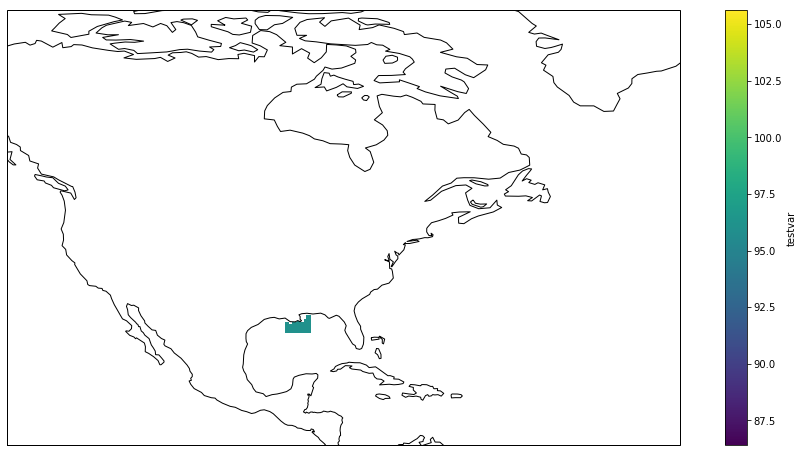

In [10]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.PlateCarree())
river_conc_face4 = river_conc.sel(face=4)
river_conc_face4['testvar'].where(river_conc_face4['testvar'] != 0).plot(ax=ax, x='lon', y='lat', 
                                                                         transform=ccrs.PlateCarree())
ax.coastlines()

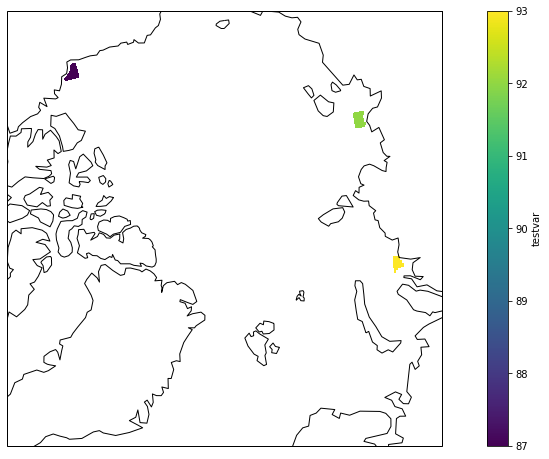

In [11]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.NorthPolarStereo())
river_conc_face4 = river_conc.sel(face=2)
river_conc_face4['testvar'].where(river_conc_face4['testvar'] != 0).plot(ax=ax, x='lon', y='lat', 
                                                                         transform=ccrs.PlateCarree())
ax.coastlines()

We can save the end result to a netcdf file using xarray *to_netcdf* function or save to a binary file using the xmitgcm package.
See https://xmitgcm.readthedocs.io/en/latest/demo_writing_binary_file.html